# Twitter US Airline Sentiment

## Background and Context:

Twitter possesses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other hand, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.


Listening to how customers feel about the product/service on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry.

## Objective
In this project we will build a classification model to identify the sentiment of a tweet about US airline so as to classify the tweet as *Positive*, *Negatige* or *Neutral*

## Data Description:

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

 

# Dataset:

The dataset has the following columns:

* tweet_id                                        
* airline_sentiment                                               
* airline_sentiment_confidence                               
* negativereason                                                   
* negativereason_confidence                                    
* airline
* airline_sentiment_gold                                              
* name     
* negativereason_gold 
* retweet_count
* text
* tweet_coord
* tweet_created
* tweet_location 
* user_timezone

## Initial setup

Let's start by importing the required libraries, setting up some basic configurations for EDA.

We will also write some basic functions to help us visualize the data.

In [1]:
# !pip install contractions

In [2]:
# import necessary libraries.


import re, string, unicodedata
import contractions 
from bs4 import BeautifulSoup                           

import numpy as np                                      
import pandas as pd                                     
import nltk                                             

nltk.download('stopwords')                              
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       
from nltk.tokenize import word_tokenize, sent_tokenize  
from nltk.stem.wordnet import WordNetLemmatizer         
import matplotlib.pyplot as plt                         

import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None, hue=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    hue: Grouping variable
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if hue is None:
        space = 5
    else:
        space = 7
    if n is None:
        plt.figure(figsize=(count + space, space))
    else:
        plt.figure(figsize=(n + space, space))

    plt.xticks(rotation=30, fontsize=8)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
        hue=hue,
    )
    if hue is not None:
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title=hue)
    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
            
        )  # annotate the percentage
    plt.show()  # show the plot

In [4]:
# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(
        data[predictor], data[target], margins=True
    ).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 75)
    tab = pd.crosstab(
        data[predictor], 
        data[target], 
        normalize="index"
    ).sort_values(by=sorter, ascending=False)

    ax = tab.plot(kind="bar", stacked=True, figsize=(count + 6, 5))

    # for c in ax.containers:
    #     ax.bar_label(c, label_type="center", size=14, fmt="%.2f")

    plt.xticks(rotation=30, fontsize=8)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title=target)
    plt.show()

In [5]:
# Removes the limit from the number of displayed columns
pd.set_option("display.max_columns", None)

# Let's set the limit of 200 rows max
pd.set_option("display.max_rows", 200)

# lets set the floats to display upto 5 decimals
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [6]:
# make the graphs look nicer
sns.set(color_codes=True)
sns.set_style("darkgrid")
# light palette for Pivot tables
cm = sns.light_palette("lightblue", as_cmap=True)
sns.set(
    rc={
        "figure.figsize": (15, 15),
        "axes.titlesize": "30",
        "xtick.labelsize": "20",
        "ytick.labelsize": "20",
    }
)

# actually display the graphs instead of generating only the object
%matplotlib inline

## Data Summary

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# read the data
data = pd.read_csv('drive/My Drive/AIML/Tweets.csv')

In [9]:
# lte's take a look at the sample data
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.00000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.34860,NaN,0.00000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.68370,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.00000,Bad Flight,0.70330,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.00000,Can't Tell,1.00000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [10]:
data.shape

(14640, 15)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [12]:
data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,14640.00000,14640.00000,10522.00000,14640.00000
mean,569218351767382528.00000,0.90017,0.63830,0.08265
std,779111158481836.75000,0.16283,0.33044,0.74578
min,567588278875213824.00000,0.33500,0.00000,0.00000
25%,568559178101439488.00000,0.69230,0.36060,0.00000
50%,569477857923110912.00000,1.00000,0.67060,0.00000
75%,569890473289000960.00000,1.00000,1.00000,0.00000
max,570310600460525568.00000,1.00000,1.00000,44.00000


In [13]:
data.describe(include="object").T

,count,unique,top,freq
airline_sentiment,14640,3,negative,9178
negativereason,9178,10,Customer Service Issue,2910
airline,14640,6,United,3822
airline_sentiment_gold,40,3,negative,32
name,14640,7701,JetBlueNews,63
negativereason_gold,32,13,Customer Service Issue,12
text,14640,14427,@united thanks,6
tweet_coord,1019,832,"[0.0, 0.0]",164
tweet_created,14640,14247,2015-02-24 09:54:34 -0800,5
tweet_location,9907,3081,"Boston, MA",157


In [14]:
#  lets identify the columns with null values
data.columns[data.isna().any()].to_list()

['negativereason',
 'negativereason_confidence',
 'airline_sentiment_gold',
 'negativereason_gold',
 'tweet_coord',
 'tweet_location',
 'user_timezone']

### Observations:
* There are 14640 rows and 15 columns in the data
* 7 columns have null or missing values
* *airline_sentiment_confidence*, *negativereason_confidence*, *retweet_count* columns have numeric values
* Most of the tweets have negative sentiments. We will be dealing with imballanced data
* Most of the negative sentiment reasons are *Customer Service Issue*
* Maximum number of tweets are about *United* Airlines
* It looks like we will only be using the *text* and *airline_sentiment* columns for building the model. We will use some of the other coulmns in EDA but drop them later

## Exploratory data analysis


### Distribution of Tweets by Airline

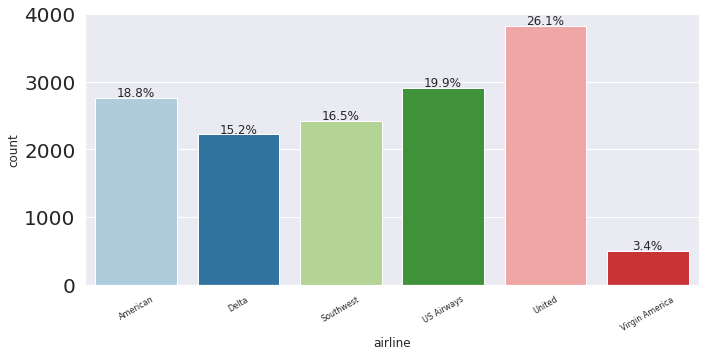

In [15]:
labeled_barplot(data, "airline", perc=True)

#### Observations
* Highest percentage of tweets are for *United* - 26.1%
* least percentage of tweets are for *Virgin America* - 3.4%

### Distribution of Tweets by Sentiment

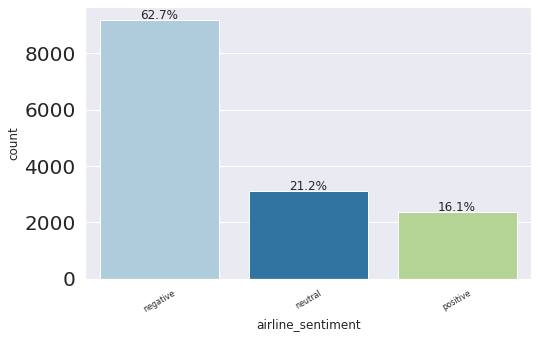

In [16]:
labeled_barplot(data, "airline_sentiment", perc=True)

#### Observations
* 62.7% tweets indicate negative sentiments for the airline
* only 16.1% tweets show a positive sentiment for the aorline

### Distribution of Sentiment of tweets for each airline

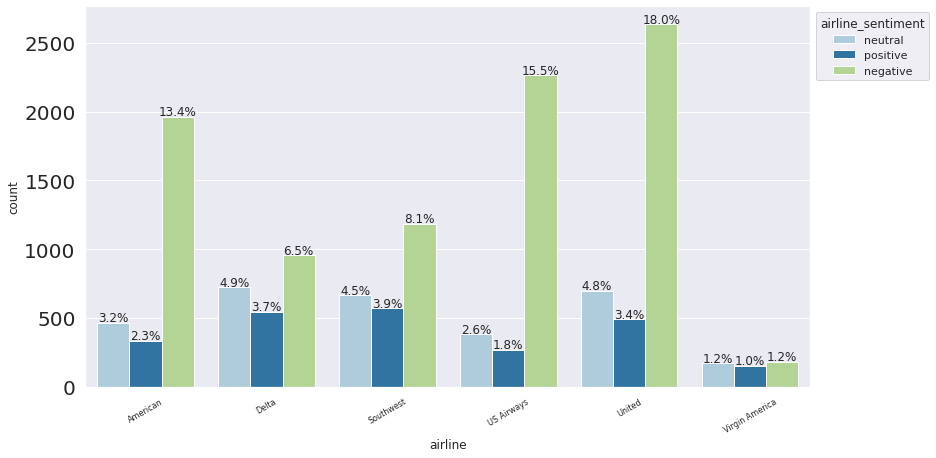

In [17]:
labeled_barplot(data, "airline", perc=True, hue="airline_sentiment")

airline_sentiment  negative  neutral  positive    All
airline                                              
All                    9178     3099      2363  14640
Southwest              1186      664       570   2420
Delta                   955      723       544   2222
United                 2633      697       492   3822
American               1960      463       336   2759
US Airways             2263      381       269   2913
Virgin America          181      171       152    504
---------------------------------------------------------------------------


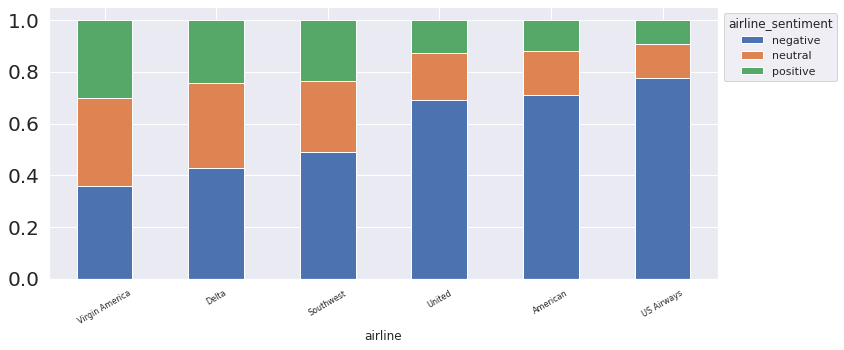

In [18]:
stacked_barplot(data, "airline", "airline_sentiment")

#### Observations
* For most of the airlines negative sentiments are more than positive or neutral
* United has the most number of negative sentiments
* Southwesst has most number of positive sentiments

### Distribution of the negative reasons

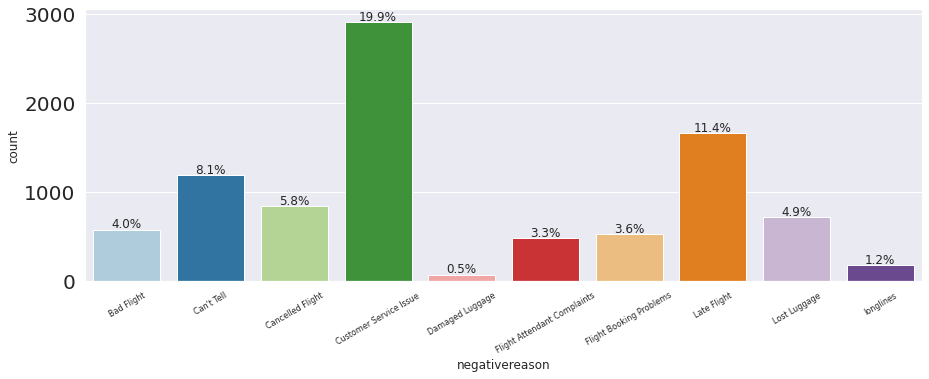

In [19]:
labeled_barplot(data, "negativereason", perc=True)

#### Observations
* *Customer service issues* are the reasons for most negative tweets about airliness
* *Late flights* are the 2nd biggest reason for the negative tweets
* It will be helpful for the Airlines to find out what kind of issues are faced in customer service and try to address those. This may help in channging the sentiment from negative to positive.
* Airliness should also focus on trying to keep the flights on time

## Understanding of Data Columns

As observed earlier, we will only need the ***text*** and ***airline_sentiment*** columns for model building. 

Though the other columns providd us some insights for EDA, they are not actually useful for the model bulding process.

We will be dropping all the not required columns.

In [20]:
# keep a backup copy of the data
data_bkp = data.copy()

In [21]:
# use only the required columns
data = data[["text", "airline_sentiment"]]
data.shape

(14640, 2)

In [22]:
# set the max column width to None so that the entirre text is printed
pd.set_option('display.max_colwidth', None)
# lets take a look at the first 5 rows
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative


## Data Pre-Processing

### Html tag removal

In [23]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

data['text'] = data['text'].apply(lambda x: strip_html(x))
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative


### Fix Contractions

In [24]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

data['text'] = data['text'].apply(lambda x: replace_contractions(x))
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you have added commercials to the experience... tacky.,positive
2,@VirginAmerica I did not today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",negative
4,@VirginAmerica and it is a really big bad thing about it,negative


row# 1 - you've changed to you have

row# 4 - it's changed to it is

### Remove the numbers

In [25]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

data['text'] = data['text'].apply(lambda x: remove_numbers(x))
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you have added commercials to the experience... tacky.,positive
2,@VirginAmerica I did not today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",negative
4,@VirginAmerica and it is a really big bad thing about it,negative


### Tokenization

In [26]:
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) 
data.head()

,text,airline_sentiment
0,"[@, VirginAmerica, What, @, dhepburn, said, .]",neutral
1,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]",positive
2,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]",neutral
3,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]",negative
4,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]",negative


### Removal of Special Characters and Punctuations

In [27]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

data['text'] = data['text'].apply(lambda x: remove_non_ascii(x))
data['text'] = data['text'].apply(lambda x: remove_punctuation(x))

data.head()

,text,airline_sentiment
0,"[VirginAmerica, What, dhepburn, said]",neutral
1,"[VirginAmerica, plus, you, have, added, commercials, to, the, experience, tacky]",positive
2,"[VirginAmerica, I, did, not, today, Must, mean, I, need, to, take, another, trip]",neutral
3,"[VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]",negative
4,"[VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]",negative


### Conversion to lowercase

In [28]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

data['text'] = data['text'].apply(lambda x: to_lowercase(x))

data.head()

,text,airline_sentiment
0,"[virginamerica, what, dhepburn, said]",neutral
1,"[virginamerica, plus, you, have, added, commercials, to, the, experience, tacky]",positive
2,"[virginamerica, i, did, not, today, must, mean, i, need, to, take, another, trip]",neutral
3,"[virginamerica, it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]",negative
4,"[virginamerica, and, it, is, a, really, big, bad, thing, about, it]",negative


### Removal of stopwords

In [29]:
stopwords = stopwords.words('english')

# Set custom stop-word's list 
# as not, couldn't etc. words matter in Sentiment,
# so not removing them from original data.

customlist = [
    'not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 
    'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
    "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 
    'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', 
    "won't", 'wouldn', "wouldn't"
]

stopwords = list(set(stopwords) - set(customlist))   

In [30]:
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

data['text'] = data['text'].apply(lambda x: remove_stopwords(x))

data.head()

,text,airline_sentiment
0,"[virginamerica, dhepburn, said]",neutral
1,"[virginamerica, plus, added, commercials, experience, tacky]",positive
2,"[virginamerica, not, today, must, mean, need, take, another, trip]",neutral
3,"[virginamerica, really, aggressive, blast, obnoxious, entertainment, guests, faces, little, recourse]",negative
4,"[virginamerica, really, big, bad, thing]",negative


### Lemmatize

In [31]:
lemmatizer = WordNetLemmatizer()

airline_names = [
    "southwest",
    "delta",    
    "united",      
    "american",    
    "us airways",
    "usairways",  
    "virgin america",
    "virginamerica",
]
def lemmatize_list(words):
    new_words = []
    for word in words:
        if word in airline_names:
            new_words.append(word)
        else:
            new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

data['text'] = data['text'].apply(lambda x: lemmatize_list(x))

data.head()


,text,airline_sentiment
0,"[virginamerica, dhepburn, say]",neutral
1,"[virginamerica, plus, add, commercials, experience, tacky]",positive
2,"[virginamerica, not, today, must, mean, need, take, another, trip]",neutral
3,"[virginamerica, really, aggressive, blast, obnoxious, entertainment, guests, face, little, recourse]",negative
4,"[virginamerica, really, big, bad, thing]",negative


### Join to convert back to text string

In [32]:
data['text'] = data['text'].apply(lambda x: " ".join(x))

data.head()

,text,airline_sentiment
0,virginamerica dhepburn say,neutral
1,virginamerica plus add commercials experience tacky,positive
2,virginamerica not today must mean need take another trip,neutral
3,virginamerica really aggressive blast obnoxious entertainment guests face little recourse,negative
4,virginamerica really big bad thing,negative


## Word Cloud based on sentiment

In [33]:
def show_wordcloud(data, title, colormap='viridis'):
    text = ' '.join(data['text'].astype(str).tolist())  
    # instantiate the stopwords from wordcloud               
    stopwords = set(wordcloud.STOPWORDS)                                  
    #  Setting the different parameter of stopwords
    fig_wordcloud = wordcloud.WordCloud(
        stopwords=stopwords,
        background_color='lightgrey', 
        colormap=colormap, 
        width=800, 
        height=600
    ).generate(text)
    
    plt.figure(figsize=(14,11), frameon=True)                             
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()

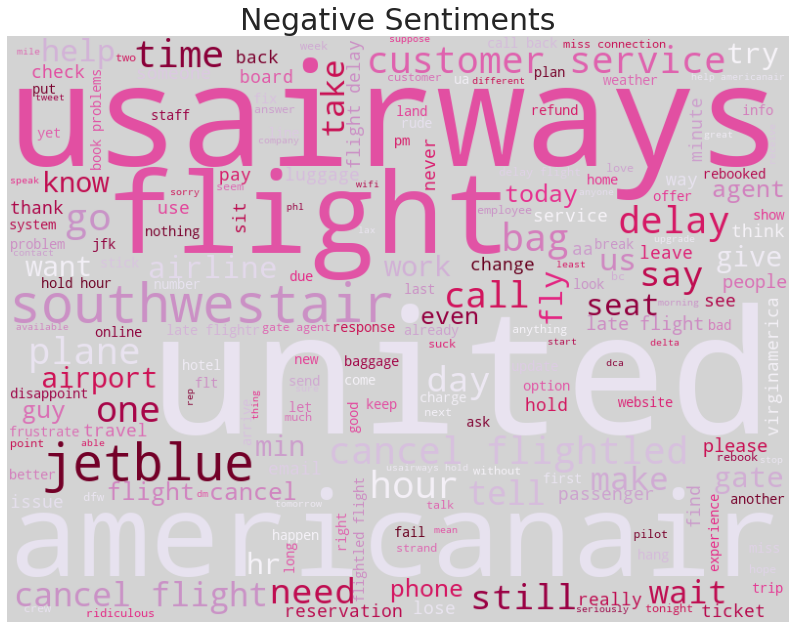

In [34]:
show_wordcloud(
    data[data["airline_sentiment"] == "negative"], 
    "Negative Sentiments",
    "PuRd"
)

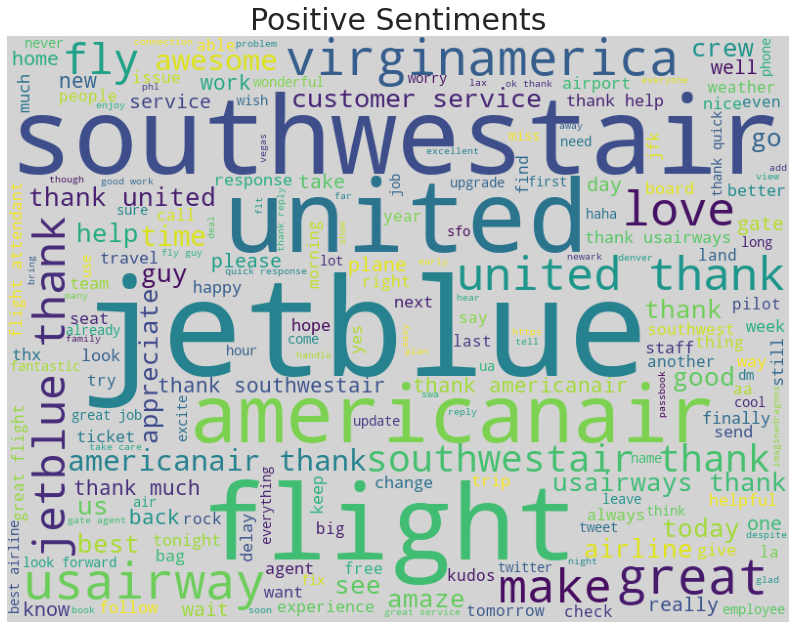

In [35]:
show_wordcloud(
    data[data["airline_sentiment"] == "positive"], 
    "Positive Sentiments",
)

#### Observations
* united, us airways & american air appear as prominent terms in both negative and positive wordclouds
* delay, bag, late & cancel are some terms observed only in negative wordcloud
* virginamerica, love, great & thank are some of the terms ovserved only in the positive wordcloud

## Vectorization

Let's now convert the data to format suitable to build the model

We will be using ***CountVectorizer*** and ***TfidfVectorizer*** 

### CountVectorizer

In [36]:
bow_vec = CountVectorizer()                
bow_features = bow_vec.fit_transform(data['text'])
# Convert the data features to array.
bow_features = bow_features.toarray()
bow_features.shape

(14640, 12048)

### TfidfVectorizer

In [37]:
tfidf_vec = TfidfVectorizer()
tfidf_features = tfidf_vec.fit_transform(data['text'])
# Convert the data features to array.
tfidf_features = tfidf_features.toarray()
tfidf_features.shape

(14640, 12048)

## Model Building

We will be building two separate models using the CountVectorizer features and TfidfVectorizer features

In [38]:
#  target variable
labels = data['airline_sentiment']

### Model using CountVectorizer features

In [39]:
# Split data into training and testing set.
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    bow_features, 
    labels, 
    test_size=0.3, 
    random_state=42
)

In [40]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.
forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest = forest.fit(X_train_bow, y_train_bow)

print(forest)

print(np.mean(cross_val_score(forest, bow_features, labels, cv=5)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.6985655737704919


#### Model Tuning

In [43]:
# create a list for no of estimators
base_ln = list(range(1, 26))

In [44]:
# K - Fold Cross Validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(
        clf, X_train_bow, y_train_bow, cv = 5, scoring = 'accuracy'
    )
    cv_scores.append(scores.mean())

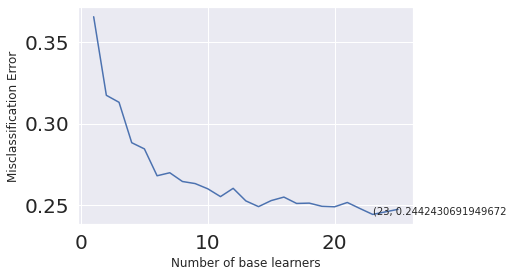

Optimal number of estimators: 23
Min Error: 0.2442430691949672


In [50]:
# plotting the error as k increases

#error corresponds to each nu of estimator
error = [1 - x for x in cv_scores]
#Selection of optimal nu of n_estimator corresponds to minimum error.
optimal_learners = base_ln[error.index(min(error))]
#Plot between each nu of estimator and misclassification error
plt.plot(base_ln, error)
xy = (optimal_learners, min(error))
plt.annotate(f'({optimal_learners}, {min(error)}', xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

print(f"Optimal number of estimators: {optimal_learners}")
print(f"Min Error: {min(error)}")

#### Model Evaluation

In [61]:
# Training the best model and calculating accuracy on test data .
tuned_bow_clf = RandomForestClassifier(n_estimators = optimal_learners)
tuned_bow_clf.fit(X_train_bow, y_train_bow)
tuned_bow_score = tuned_bow_clf.score(X_test_bow, y_test_bow)


In [81]:
print(f"Accuracy for the Tuned Random Forest model using CountVectorizer is {tuned_bow_score*100:.2f}%")

Accuracy for the Tuned Random Forest model using CountVectorizer is 77.19%


In [80]:
result_bow =  tuned_bow_clf.predict(X_test_bow) 

f1_score_bow = metrics.f1_score(y_test_bow, result_bow, average='micro')
print(f"F1 Score for the Tuned Random Forest model using CountVectorizer is {f1_score_bow}")

F1 Score for the Tuned Random Forest model using CountVectorizer is 0.7718579234972677


##### Confusion Matrix

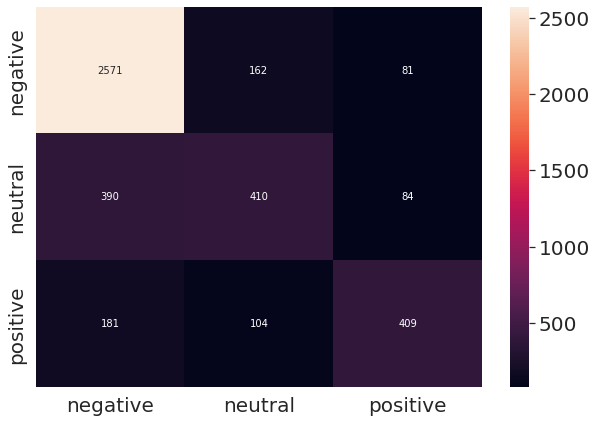

In [74]:
# plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
conf_mat_bow = confusion_matrix(y_test_bow, result_bow)
df_cm = pd.DataFrame(
    conf_mat_bow, 
    index = ["negative", "neutral", "positive"],
    columns = ["negative", "neutral", "positive"]
)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

##### Top Features

In [79]:
#Instantiate the feature from the vectorizer
bow_feature_names = bow_vec.get_feature_names_out()
# top 40 features after training the model
bow_top_features = []
bow_feat = tuned_bow_clf.feature_importances_
bow_features = np.argsort(bow_feat)[::-1]
for i in bow_features[0:40]:
    bow_top_features.append(bow_feature_names[i])

print("Top 40 features of the Tuned Random Forest model using CountVectorizer")
print(np.array(bow_top_features).reshape(8, 5))

Top 40 features of the Tuned Random Forrest model using CountVectorizer
[['thank' 'not' 'great' 'usairways' 'jetblue']
 ['delay' 'flight' 'http' 'hold' 'united']
 ['hours' 'southwestair' 'cancel' 'love' 'americanair']
 ['bag' 'get' 'virginamerica' 'wait' 'amaze']
 ['call' 'awesome' 'service' 'customer' 'dm']
 ['please' 'still' 'follow' 'help' 'fleet']
 ['time' 'plane' 'would' 'make' 'miss']
 ['best' 'hour' 'fly' 'need' 'late']]


##### Wordcloud

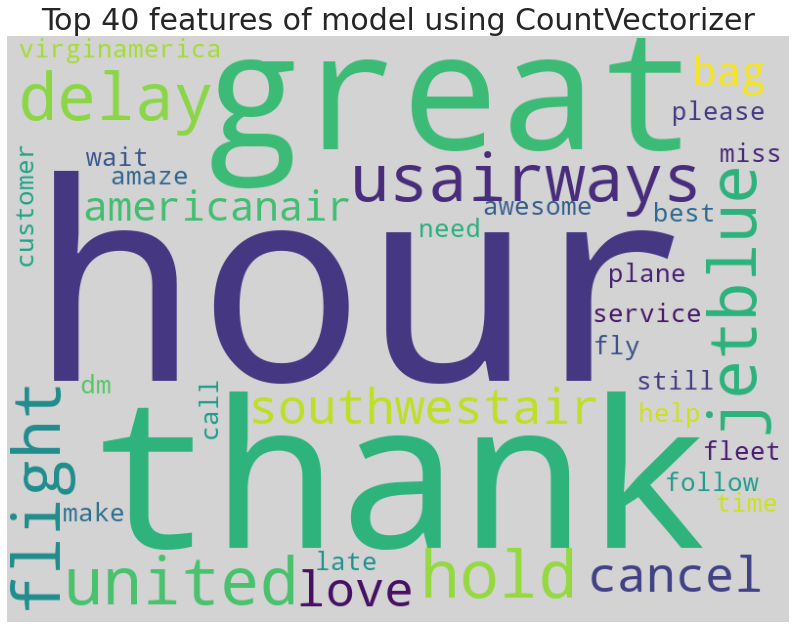

In [83]:
df = pd.DataFrame(bow_top_features, columns=["text"])
show_wordcloud(
    df, "Top 40 features of model using CountVectorizer"
)

### Model using TfidfVectorizer features

In [63]:
# Split data into training and testing set.
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    tfidf_features, 
    labels, 
    test_size=0.3, 
    random_state=42
)

In [64]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.
tfidf_forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
tfidf_forest = tfidf_forest.fit(X_train_tfidf, y_train_tfidf)

print(forest)

print(np.mean(cross_val_score(tfidf_forest, tfidf_features, labels, cv=5)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.6915300546448087


#### Model Tuning

In [65]:
# K - Fold Cross Validation .
tfidf_cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(
        clf, X_train_tfidf, y_train_tfidf, cv = 5, scoring = 'accuracy'
    )
    tfidf_cv_scores.append(scores.mean())

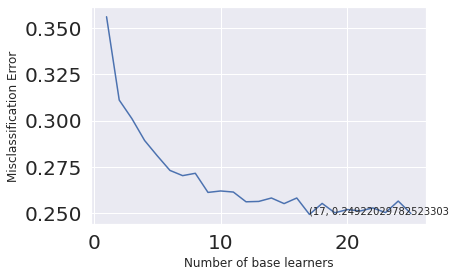

Optimal number of estimators: 17
Min Error: 0.24922029782523303


In [66]:
# plotting the error as k increases

#error corresponds to each nu of estimator
tfidf_error = [1 - x for x in tfidf_cv_scores]
#Selection of optimal nu of n_estimator corresponds to minimum error.
tfidf_optimal_learners = base_ln[tfidf_error.index(min(tfidf_error))]
#Plot between each nu of estimator and misclassification error
plt.plot(base_ln, tfidf_error)
xy = (tfidf_optimal_learners, min(tfidf_error))
plt.annotate(
    f'({tfidf_optimal_learners}, {min(tfidf_error)}',
    xy = xy, 
    textcoords='data'
)
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

print(f"Optimal number of estimators: {tfidf_optimal_learners}")
print(f"Min Error: {min(tfidf_error)}")

#### Model Evaluation

In [67]:
# Training the best model and calculating accuracy on test data .
tuned_tfidf_clf = RandomForestClassifier(n_estimators = tfidf_optimal_learners)
tuned_tfidf_clf.fit(X_train_tfidf, y_train_tfidf)
tuned_tfidf_score = tuned_tfidf_clf.score(X_test_tfidf, y_test_tfidf)


In [69]:
print(f"Accuracy for the Tuned Random Forrest model using TfidfVectorizer is {tuned_tfidf_score*100:.2f}%")

Accuracy for the Tuned Random Forrest model using TfidfVectorizer is 76.84%


In [84]:
result_tfidf =  tuned_tfidf_clf.predict(X_test_bow) 

f1_score_tfidf = metrics.f1_score(y_test_tfidf, result_tfidf, average='micro')
print(f"F1 Score for the Tuned Random Forest model using TfidfVectorizer is {f1_score_tfidf}")

F1 Score for the Tuned Random Forest model using TfidfVectorizer is 0.7078779599271403


##### Confusion Matrix

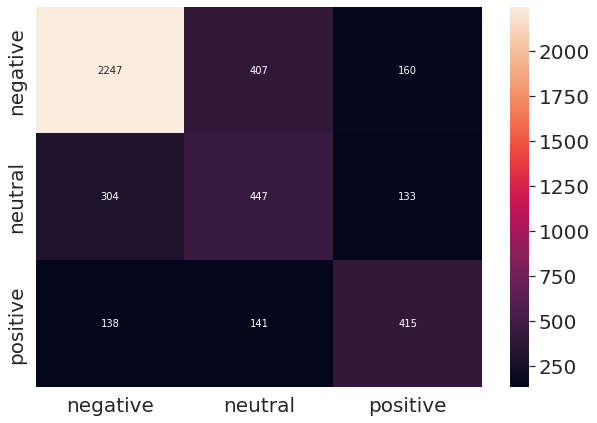

In [85]:
# plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
conf_mat_tfidf = confusion_matrix(y_test_tfidf, result_tfidf)
df_cm = pd.DataFrame(
    conf_mat_tfidf, 
    index = ["negative", "neutral", "positive"],
    columns = ["negative", "neutral", "positive"]
)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

##### Top Features

In [86]:
#Instantiate the feature from the vectorizer
tfidf_feature_names = tfidf_vec.get_feature_names_out()
# top 40 features after training the model
tfidf_top_features = []
tfidf_feat = tuned_tfidf_clf.feature_importances_
tfidf_features = np.argsort(tfidf_feat)[::-1]
for i in tfidf_features[0:40]:
    tfidf_top_features.append(tfidf_feature_names[i])

print("Top 40 features of the Tuned Random Forest model using TfidfVectorizer")
print(np.array(tfidf_top_features).reshape(8, 5))

Top 40 features of the Tuned Random Forest model using TfidfVectorizer
[['thank' 'not' 'jetblue' 'united' 'southwestair']
 ['americanair' 'usairways' 'flight' 'http' 'great']
 ['love' 'delay' 'hours' 'get' 'hold']
 ['wait' 'virginamerica' 'service' 'amaze' 'follow']
 ['bag' 'please' 'hour' 'customer' 'dm']
 ['time' 'good' 'appreciate' 'call' 'best']
 ['fly' 'help' 'awesome' 'need' 'plane']
 ['make' 'cancel' 'still' 'airline' 'worst']]


##### Wordcloud

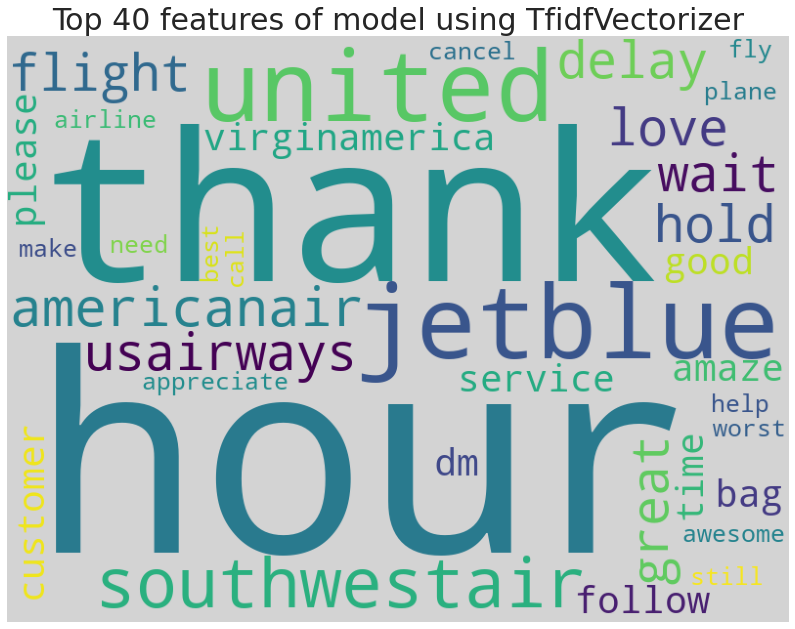

In [87]:
df = pd.DataFrame(tfidf_top_features, columns=["text"])
show_wordcloud(
    df, "Top 40 features of model using TfidfVectorizer"
)

## Conclusion / Summary
* We were provided the data from tweets related to major airlines in USA along with the sentiments as Positive, Negative or Neutral
* We used this data to buld classification models to identify the sentiments from the text in the tweet
* We preprocessed the data using various techniques 
* We plotted the wordclouds for the positive and negative sentiments
* We used CountVectorizer and TfidfVectorizer to conver the tweet text to format which can be used for model building
* We then built and tuned two separate models using the features from  the two vectorizers
* We then evaluated the two models and extracted top features for both of the models
* Accuracy for the Tuned Random Forest model using CountVectorizer is 77.19%
* Accuracy for the Tuned Random Forrest model using TfidfVectorizer is 76.84%


